In [9]:
from sklearn.model_selection import StratifiedKFold
import optuna
from torch.utils.data import DataLoader, Subset
import sys
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path, models_path
from preprocessing_modules import create_time_windows_with_labels
from CNN_classifier_model import CNNClassifier, train_model
import os
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import torch
import numpy as np

In [10]:

train_dir = os.path.join(univariate_data_path, "target_univariate_train.npy")
train_data = np.load(train_dir, allow_pickle=True)
# train_data = pd.DataFrame(train_data)

train_windows = create_time_windows_with_labels(train_data)



# Example dataset with windows and labels
train_windows, train_labels = create_time_windows_with_labels(train_data)

# Count label distribution
train_label_counts = Counter(train_labels)

# Print the counts
print("Train label distribution:")
print(f"  Term (0): {train_label_counts[0]}")
print(f"  Preterm (1): {train_label_counts[1]}")



# Convert to tensors
train_windows_tensor = torch.tensor(train_windows, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
train_dataset = TensorDataset(train_windows_tensor, train_labels_tensor)
print(train_windows_tensor.shape)  
print(train_labels_tensor.shape)  



Train label distribution:
  Term (0): 319
  Preterm (1): 752
torch.Size([1071, 12000])
torch.Size([1071])


In [11]:
from sklearn.metrics import average_precision_score
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold

def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Hyperparameter suggestions
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    num_layers = trial.suggest_int("num_layers", 2, 5)
    base_channels = trial.suggest_categorical("base_channels", [8, 16, 32])

    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = 5 

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_ap_scores = []

    for train_idx, val_idx in kfold.split(train_windows_tensor, train_labels_tensor):
        # Create data loaders
        train_subset = Subset(train_dataset, train_idx)
        val_subset = Subset(train_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Instantiate model
        model = CNNClassifier(input_length=12000, num_layers=num_layers, base_channels=base_channels)

        # Train model
        trained_model = train_model(model, train_loader, val_loader, epochs=epochs, lr=lr, device=device)

        # Evaluate on validation set using AP
        y_true_all = []
        y_probs_all = []
        trained_model.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch = x_batch.unsqueeze(1).to(device)
                y_batch = y_batch.to(device)

                outputs = trained_model(x_batch)
                probs = torch.sigmoid(outputs).squeeze().cpu().numpy()

                y_true_all.extend(y_batch.cpu().numpy())
                y_probs_all.extend(probs)

        ap = average_precision_score(y_true_all, y_probs_all)
        fold_ap_scores.append(ap)

    return np.mean(fold_ap_scores)


In [12]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)

print("Best trial:")
print(study.best_trial)


[I 2025-04-28 09:11:37,704] A new study created in memory with name: no-name-f3f9edb0-3f47-4c74-8356-44c19a11bec5
/scratch-local/nwertheim.11417819/ipykernel_1375003/312563275.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
[I 2025-04-28 09:22:05,981] Trial 0 finished with value: 0.825085733666692 and parameters: {'lr': 2.2958725751657965e-05, 'num_layers': 4, 'base_channels': 16, 'batch_size': 32}. Best is trial 0 with value: 0.825085733666692.
/scratch-local/nwertheim.11417819/ipykernel_1375003/312563275.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
[I 2025-04-28 

Best trial:
FrozenTrial(number=12, state=1, values=[0.834695486164847], datetime_start=datetime.datetime(2025, 4, 28, 11, 5, 43, 541434), datetime_complete=datetime.datetime(2025, 4, 28, 11, 24, 36, 706455), params={'lr': 0.00012403724372113712, 'num_layers': 5, 'base_channels': 32, 'batch_size': 16}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'num_layers': IntDistribution(high=5, log=False, low=2, step=1), 'base_channels': CategoricalDistribution(choices=(8, 16, 32)), 'batch_size': CategoricalDistribution(choices=(16, 32, 64))}, trial_id=12, value=None)


In [13]:
import os
import joblib
path = os.path.join(models_path, "cnn_baseline_optuna.pkl")
joblib.dump(study, path)
print(f"Saved Optuna study to {path}")

Saved Optuna study to ../models/cnn_baseline_optuna.pkl


/scratch-local/nwertheim.11417819/ipykernel_1375003/3187846317.py:13: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


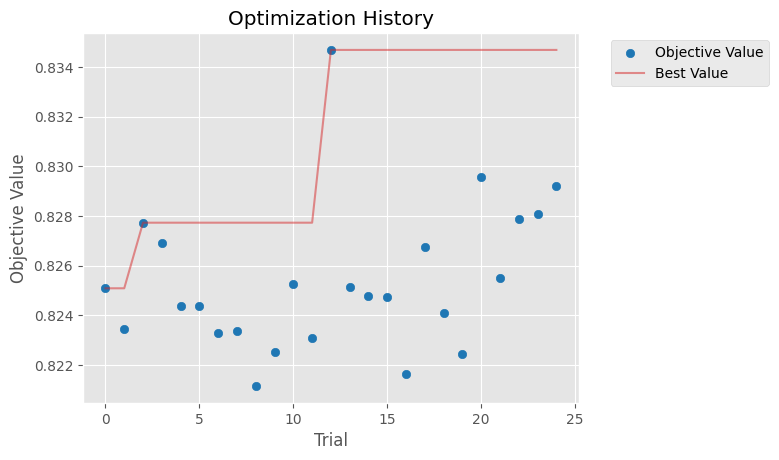

/scratch-local/nwertheim.11417819/ipykernel_1375003/3187846317.py:19: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


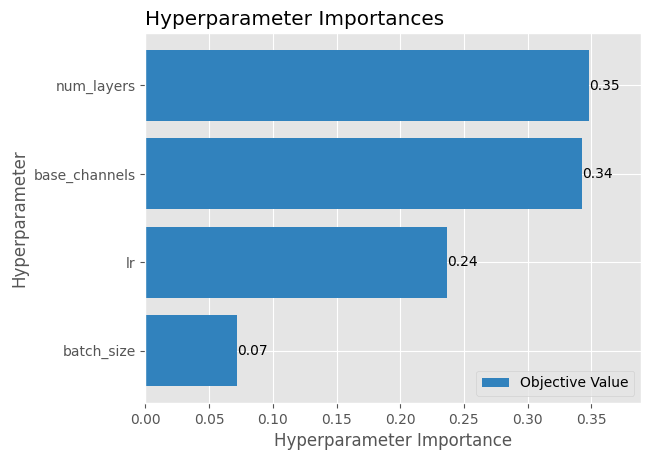

/scratch-local/nwertheim.11417819/ipykernel_1375003/3187846317.py:25: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study)


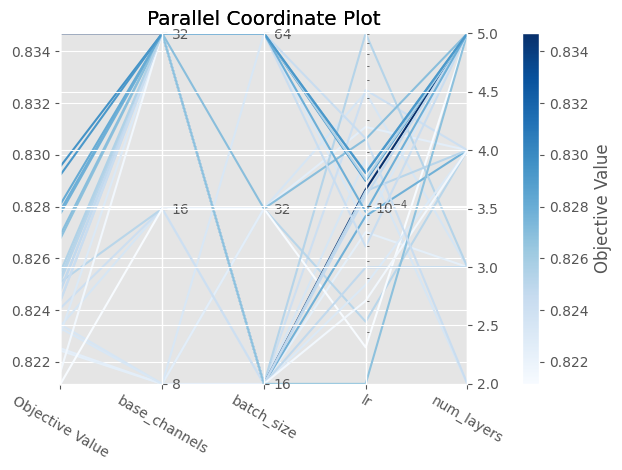

In [14]:
import os
import joblib
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate
import matplotlib.pyplot as plt


path = os.path.join(models_path, "cnn_baseline_optuna.pkl")
# Load the saved study
study = joblib.load(path)

# Plot: Optimization History
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optimization History")
# plt.tight_layout()
plt.show()

# Plot: Hyperparameter Importance
optuna.visualization.matplotlib.plot_param_importances(study)
# plt.title("Hyperparameter Importance")
# plt.tight_layout()
plt.show()

# Plot: Parallel Coordinates (shows interaction between parameters)
optuna.visualization.matplotlib.plot_parallel_coordinate(study)
plt.title("Parallel Coordinate Plot")
plt.tight_layout()
plt.show()
